In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import massrecon.Prelim

In [4]:
from tensorflow.keras.layers.experimental import preprocessing


In [5]:
ds, info =tfds.load('Prelim', data_dir='/home/nessa/Documents/codes/MassRecon/data',with_info=True, split='train')
ds = ds.map(lambda x: x['image'])

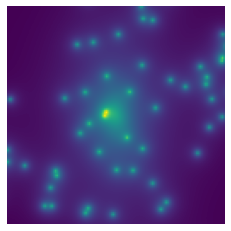

7.1927223 0.21732591


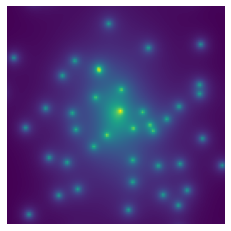

6.82323 0.24915245


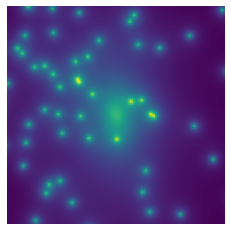

5.822584 0.2667928


In [6]:
for datum in tfds.as_numpy(ds.take(3)):
    plt.imshow(datum)
    plt.axis('off')
    plt.show()
    print(max(datum.flatten()), min(datum.flatten()))

In [7]:
maximum = 0
minimum = 10
for datum in tfds.as_numpy(ds):
    if max(datum.flatten())>maximum:
        maximum = max(datum.flatten()) 
    if min(datum.flatten())<minimum:
        minimum = min(datum.flatten()) 

In [8]:
print(maximum, minimum)

10.830819 0.17113674


In [9]:
def augmentation(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = x + 0.001*tf.random.normal(shape=(128,128,1))
    return x

In [12]:
def log(x):
    return tf.math.log(x)

In [29]:
layer_rescale = preprocessing.Rescaling(scale=1./np.ceil(maximum))

layer_normalize = preprocessing.Normalization()
layer_normalize.adapt(ds.map(log))



def duplicate(x):
    return (x ,x)

In [30]:
DATASET_SIZE = 999
BATCH_SIZE   = 16

train_size   = int(0.9 * DATASET_SIZE)
test_size    = int(0.1 * DATASET_SIZE)

train_dataset= ds.take(train_size).repeat().map(log).map(layer_normalize).map(augmentation).map(duplicate).shuffle(buffer_size=2000).batch(BATCH_SIZE)
test_dataset = ds.skip(train_size).take(test_size).map(log).map(layer_normalize).map(duplicate).batch(BATCH_SIZE)

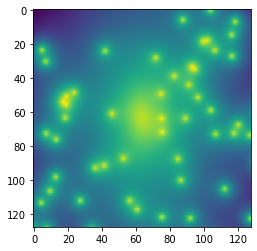

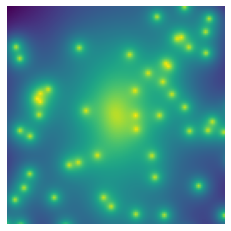

2.8789783 -2.5677662 0.05764118 0.9011101


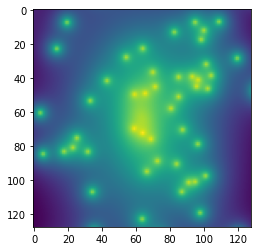

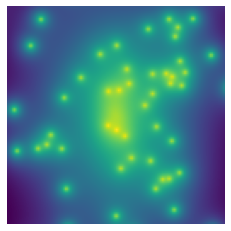

3.19968 -2.4077425 -0.083386295 1.10869


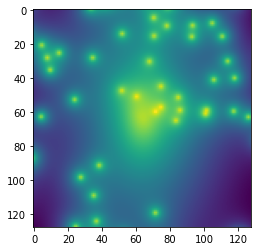

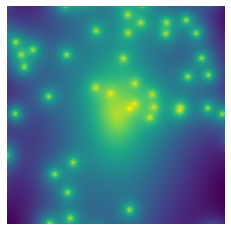

2.9877777 -2.2410736 -0.13720983 0.9817575


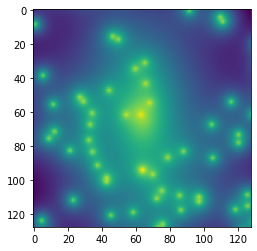

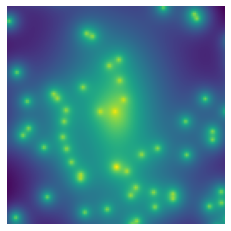

3.4343865 -2.128002 0.056219026 0.985925


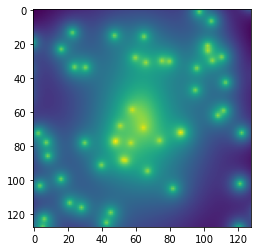

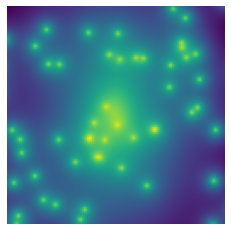

3.4495735 -2.1223016 0.013691813 0.9661483


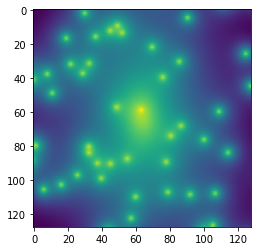

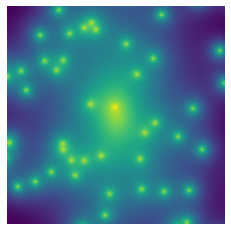

3.1786406 -2.0452392 -0.051768757 0.9419009


In [31]:
# auto encoder
for datum in tfds.as_numpy(train_dataset.take(3)):
    plt.imshow(datum[0][0])
    plt.show()
    plt.imshow(datum[1][0])
    plt.axis('off')
    plt.show()
    print(datum[0][0].max(),datum[0][0].min(), datum[0][0].mean(),datum[0][0].std())
    
# auto encoder
for datum in tfds.as_numpy(test_dataset.take(3)):
    plt.imshow(datum[0][0])
    plt.show()
    plt.imshow(datum[1][0])
    plt.axis('off')
    plt.show()
    print(datum[0][0].max(),datum[0][0].min(), datum[0][0].mean(),datum[0][0].std())

In [32]:
import tensorflow.keras.layers as layers

In [33]:
latent_dim = 128

encoder_inputs = tf.keras.Input(shape=(128, 128, 1))

x = layers.LeakyReLU()(layers.Conv2D(64, 4, strides=2)(encoder_inputs))
x = layers.Conv2D(64,4, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)#1024
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
z_mean  = tf.keras.layers.Dense(latent_dim, name="z")(x)
encoder = tf.keras.Model(encoder_inputs,z_mean, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 63, 64)        1088      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        65600     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0   

In [34]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(128)(latent_inputs)#1024
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(64 * 32*32)(x)#128
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = tf.keras.layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 4, 2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_outputs = layers.Conv2DTranspose(1, 4, strides=2, padding="same", activation=None)(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 65536)             8454144   
_________________________________________________________________
batch_normalization_13 (Batc (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 65536)             0   

In [35]:
inp   = tf.keras.Input((128,128,1))
code  = encoder(inp)
recon = decoder(code)

autoencoder = tf.keras.Model(inp,recon)
autoencoder.compile(optimizer='adam', loss='mse')

In [36]:
print(autoencoder.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
encoder (Model)              (None, 128)               8472704   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 1)       8800193   
Total params: 17,272,897
Trainable params: 17,141,057
Non-trainable params: 131,840
_________________________________________________________________
None


In [37]:
history = autoencoder.fit(x=train_dataset, epochs=40,validation_data=test_dataset,steps_per_epoch=train_size//BATCH_SIZE)

Epoch 1/40
56/56 [==============================] - 22s 396ms/step - loss: 0.6165 - val_loss: 0.7193
Epoch 2/40
56/56 [==============================] - 22s 394ms/step - loss: 0.3356 - val_loss: 0.6302
Epoch 3/40
56/56 [==============================] - 22s 393ms/step - loss: 0.2975 - val_loss: 0.4621
Epoch 4/40
56/56 [==============================] - 23s 410ms/step - loss: 0.2754 - val_loss: 0.3756
Epoch 5/40
56/56 [==============================] - 28s 494ms/step - loss: 0.2635 - val_loss: 0.2898
Epoch 6/40
56/56 [==============================] - 28s 494ms/step - loss: 0.2507 - val_loss: 0.2580
Epoch 7/40
56/56 [==============================] - 28s 500ms/step - loss: 0.2425 - val_loss: 0.2585
Epoch 8/40
56/56 [==============================] - 32s 564ms/step - loss: 0.2353 - val_loss: 0.2600
Epoch 9/40
56/56 [==============================] - 29s 518ms/step - loss: 0.2282 - val_loss: 0.2403
Epoch 10/40
56/56 [==============================] - 29s 520ms/step - loss: 0.2222 - val_lo

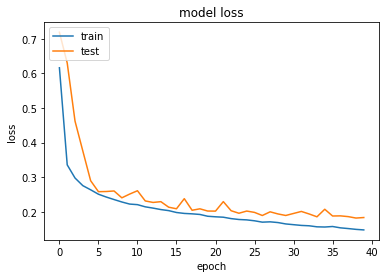

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
truth = list(test_dataset.as_numpy_iterator()) 

(16, 128, 128, 1)
(128, 128, 1)


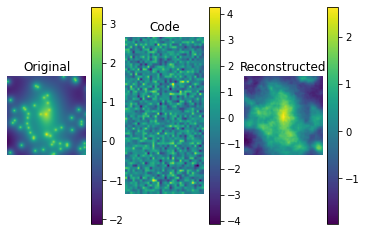

(16, 128, 128, 1)
(128, 128, 1)


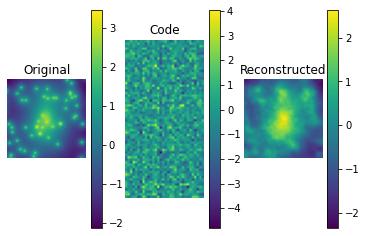

(16, 128, 128, 1)
(128, 128, 1)


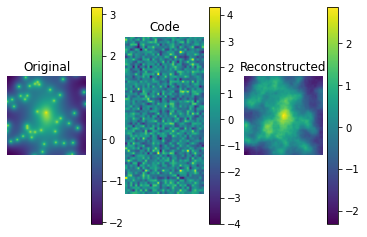

(16, 128, 128, 1)
(128, 128, 1)


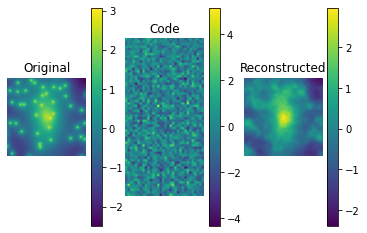

(16, 128, 128, 1)
(128, 128, 1)


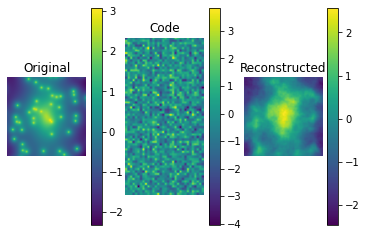

In [40]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[0])
    reco = decoder.predict(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    print(img[0].shape)
    plt.imshow(img[0][0])
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code[0].shape[-1]//2,-1]))
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    print(reco[0].shape)
    plt.imshow(reco[0])
    plt.colorbar()
    plt.axis('off')
    plt.show()

for i in range(5):
    img = truth[i]
    visualize(img,encoder,decoder)